Post process 3D bbx tracking data produced in April 2021
Goals
1. rectify 3D bbox measurements into comprehensible trajecotry data for enhancing training
2. manual validate the rectified measurements with the videos

Tasks
1. compute homography matrix (done)
2. transform bottom 4 poitns into real-world coords (done)
3. work on the road plane (done)
4. use optimization to rectify measurements (done)
5. add motion (velocity. acceleration) constraints in optimization (done)
6. optimization switch direction south/north bound
6. Apply Joint Probabilistic Data Association algorithm (JPDA)
    https://stonesoup.readthedocs.io/en/latest/auto_tutorials/08_JPDATutorial.html
    a. one object has 4 measurements

In [1]:
from utils import *
import importlib
import utils
importlib.reload(utils)
import os.path
from os import path
import pandas as pd
import utils_optimization as opt
importlib.reload(opt)
import time
from scipy.optimize import minimize,NonlinearConstraint,leastsq,fmin_slsqp,least_squares
import numpy.linalg as LA


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
data_path = pathlib.Path().absolute().joinpath('../2D-3D May 2021')
file_name = data_path.joinpath('record_p2c1_00001_track_outputs_corrected_3D.csv')
df = utils.read_data(file_name,0)
# df = df.rename(columns={'bbrx': 'bblx', 'bblx': 'bbrx', 'fblx': 'fbrx', 'fbrx': 'fblx',
#                        'bbry': 'bbly', 'bbly': 'bbry', 'fbly': 'fbry', 'fbry': 'fbly'})
# df['Timestamp'] = df['Frame #']/30
path_vpts = data_path.joinpath('camera_calibration_points_I24_validation_system.csv')
df = utils.calc_rr_coords(df, 'P2C1', path_vpts) # P1C4 good
A = [36.004654, -86.609976] # south west side, so that x, y coords obey counterclockwise
B = [36.002495, -86.607566]
df = utils.calc_xy(df,A,B)
print(len(df['ID'].unique()))
df = utils.get_x_direction(df)
df = utils.naive_filter_3D(df)
df = df[df['direction']=='+']
print(len(df['ID'].unique()))
df.head()

C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:50: RuntimeWarning: invalid value encountered in sin
  a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:50: RuntimeWarning: invalid value encountered in cos
  a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2


139


C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g[col_name]=Y[:,i]
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:279: RuntimeWarning: invalid value encountered in greater
  outliers = np.logical_or(w1>5, w2>5)
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:286: RuntimeWarning: invalid value encountered in greater
  outliers = abs(l1 - m1) > 2 * s1
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:284: RuntimeWarning: Mean of empty slice
  m1 = np.nanmean(l1)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.

73


Frame #     Timestamp     ID Object class  BBox xmin  BBox ymin  \
7         0  1.758018e+09  22261        sedan    1494.00     560.00   
15        1           NaN  22261        sedan    1502.75     571.25   
23        2           NaN  22261        sedan    1511.50     582.50   
31        3           NaN  22261        sedan    1520.25     593.75   
38        4           NaN  22261        sedan    1529.00     605.00   

    BBox xmax  BBox ymax     vel_x      vel_y  ...     bbllon      fbr_y  \
7     1574.00     636.00  3.859742  15.289554  ... -86.608601        NaN   
15    1583.75     648.25  3.859742  15.289554  ... -86.608593        NaN   
23    1593.50     660.50  3.859742  15.289554  ... -86.608585        NaN   
31    1603.25     672.75  3.859742  15.289554  ... -86.608575        NaN   
38    1613.00     685.00  3.859742  15.289554  ... -86.608567  16.756352   

        fbl_y      bbr_y     bbl_y      fbr_x       fbl_x       bbr_x  \
7         NaN        NaN       NaN        NaN         NaN         NaN   
15        NaN        NaN       NaN        NaN         NaN         NaN   
23        NaN        NaN       NaN        NaN         NaN         NaN   
31        NaN        NaN       NaN        NaN         NaN         NaN   
38  18.915901  16.742403  18.91994  173.18855  173.946528  169.719018   

         bbl_x  direction  
7          NaN          +  
15         NaN          +  
23         NaN          +  
31         NaN          +  
38  170.529296          +  

[5 rows x 46 columns]

73  unique cars
ID: 22261


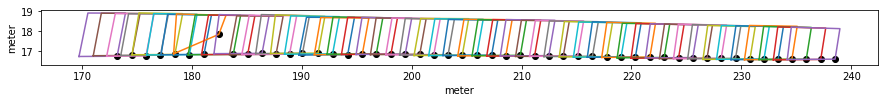

ID: 24261


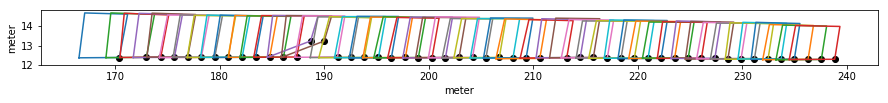

ID: 30261


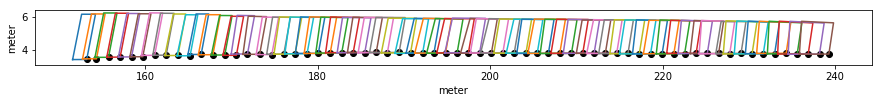

ID: 37261


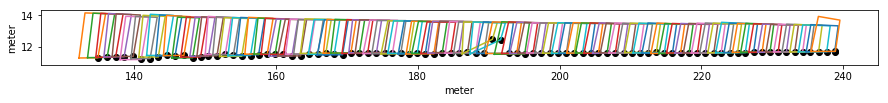

ID: 39261


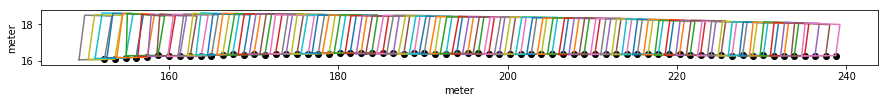

ID: 49261


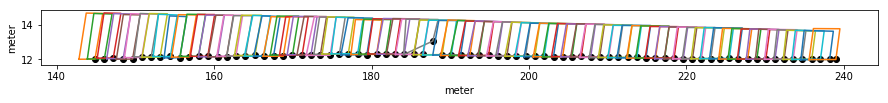

ID: 56261


KeyboardInterrupt: 

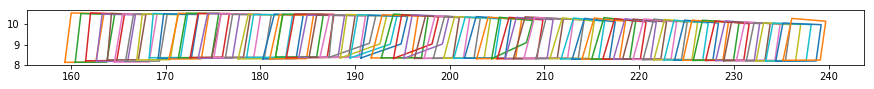

In [3]:
# plot original

# group by objects

groups = df.groupby('ID')
groupList = list(groups.groups)
nO = len(groupList) # number of cars to test
print(nO,' unique cars')

for i in range(nO):
    ID = groupList[i]
#     ID = 100261
    Y1 = groups.get_group(ID)

    # get bottom 4 points coordinates
    Y1gps = np.array(Y1[['bbrlat','bbrlon','fbrlat','fbrlon','fbllat','fbllon','bbllat','bbllon']])
    Y1 = np.array(Y1[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])

    # plot 
    print('ID:',ID)
    D = Y1
    fig, ax = plt.subplots(figsize=(15,1))

    for i in range(len(D)):
        coord = D[i,:]
        coord = np.reshape(coord,(-1,2)).tolist()
        coord.append(coord[0]) #repeat the first point to create a 'closed loop'
        xs, ys = zip(*coord) #lon, lat as x, y
        plt.plot(xs,ys)
    plt.scatter(D[:,2],D[:,3],color='black') # fbr
#     plt.scatter(D[:,0],D[:,1],color='blue') # bbr
#     plt.scatter(D[:,4],D[:,5],color='red') # fbl
    ax = plt.gca()
    plt.xlabel('meter')
    plt.ylabel('meter')
    ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
    plt.show() 


73 unique cars
ID: 22261 Valid/total timestamps: 119 / 51 score: 1.5603974963023117 runtime: 1.917912244796753 
 width: 1.855302299942494 length: 4.25823156057276


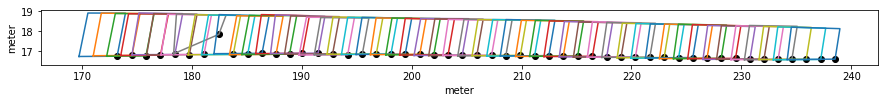

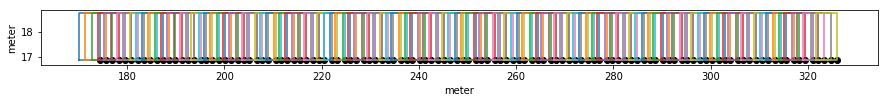

ID: 24261 Valid/total timestamps: 142 / 52 score: 0.10516406536118159 runtime: 4.773229598999023 
 width: 1.9961069011172126 length: 4.136250844692763


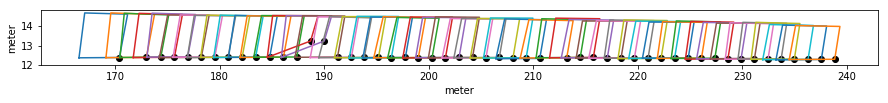

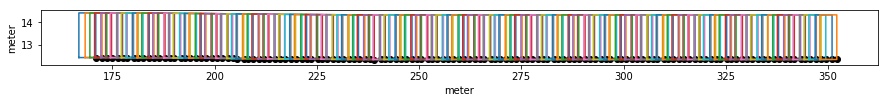

ID: 30261 Valid/total timestamps: 66 / 66 score: 0.18139155265211784 runtime: 0.6930482387542725 
 width: 2.170985731959202 length: 2.923257857433604


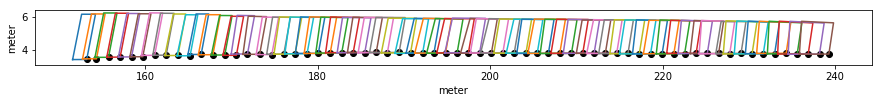

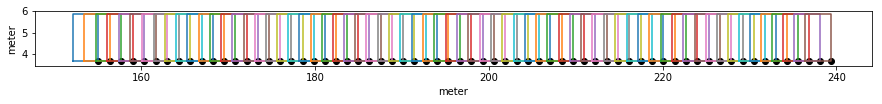

ID: 37261 Valid/total timestamps: 116 / 91 score: 0.10688744328040016 runtime: 5.422203540802002 
 width: 2.076137465501817 length: 3.817211091050915


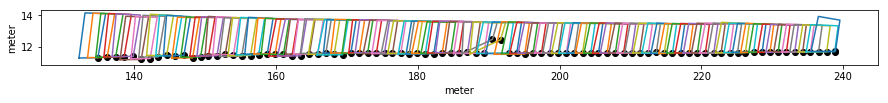

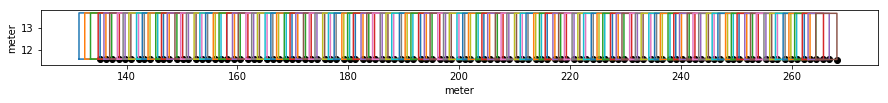

ID: 39261 Valid/total timestamps: 113 / 70 score: 2.1825318211308398 runtime: 1.6515090465545654 
 width: 2.0795028701134437 length: 4.19010920348619


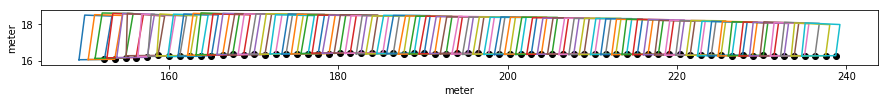

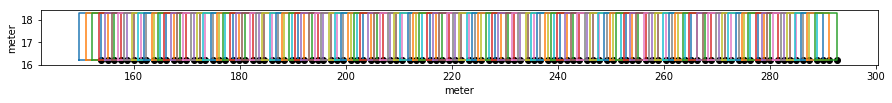

ID: 49261 Valid/total timestamps: 143 / 81 score: 0.11409592122253698 runtime: 5.016585350036621 
 width: 2.0507739643296685 length: 3.208662132163586


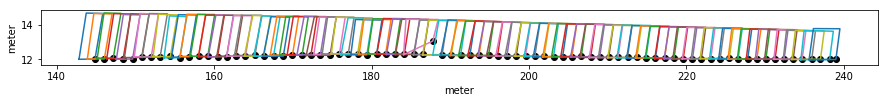

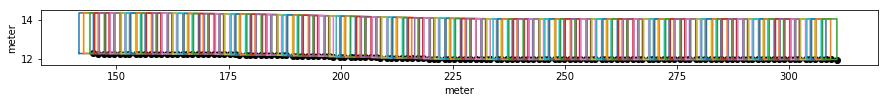

ID: 56261 Valid/total timestamps: 100 / 71 score: 0.25861142688705807 runtime: 1.5263209342956543 
 width: 2.0738967941770707 length: 3.9860002540312323


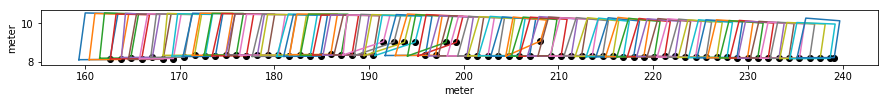

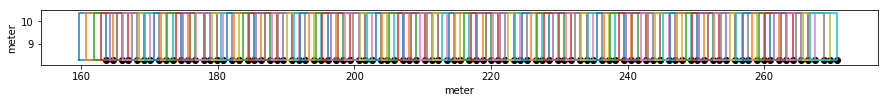

ID: 63261 Valid/total timestamps: 142 / 91 score: 0.12616412961252754 runtime: 6.186355113983154 
 width: 2.1985453457110924 length: 3.2123935981847676


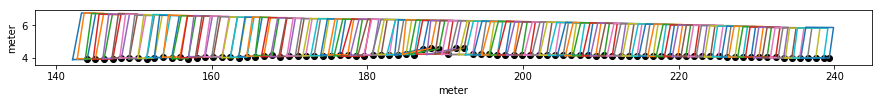

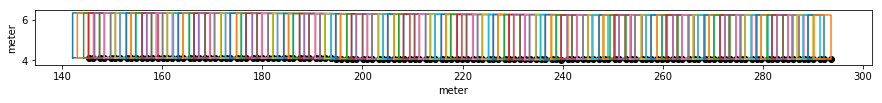

ID: 69261 Valid/total timestamps: 130 / 81 score: 0.12018201143118178 runtime: 5.0586607456207275 
 width: 2.2033375061971894 length: 4.4279151155048275


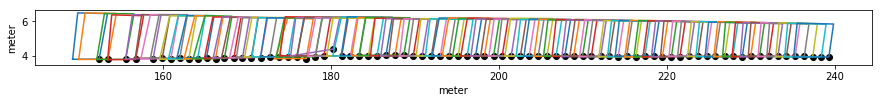

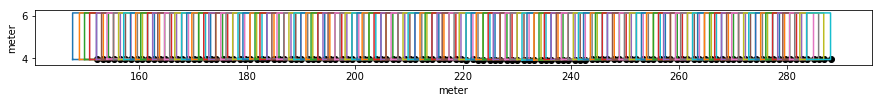

ID: 70261 Valid/total timestamps: 135 / 77 score: 0.11788697628304315 runtime: 4.3806235790252686 
 width: 1.9892420934404587 length: 3.631006995015263


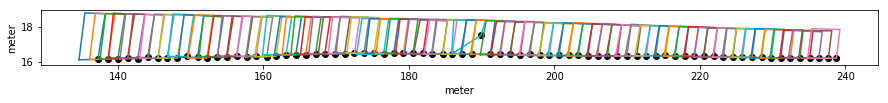

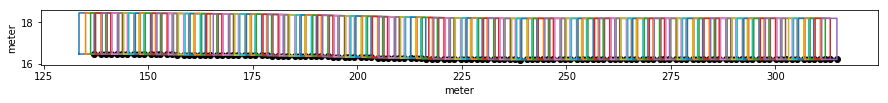

ID: 73261 Valid/total timestamps: 153 / 82 score: 0.09543512510024031 runtime: 7.196894645690918 
 width: 2.2436899242806354 length: 4.517366658975662


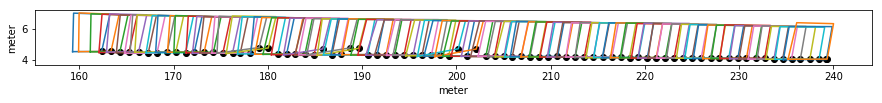

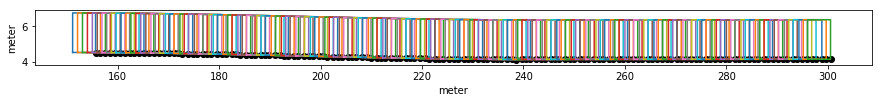

ID: 76261 Valid/total timestamps: 170 / 149 score: 0.35218158381871995 runtime: 5.654560804367065 
 width: 3.1323653674429606 length: 18.261134098470738


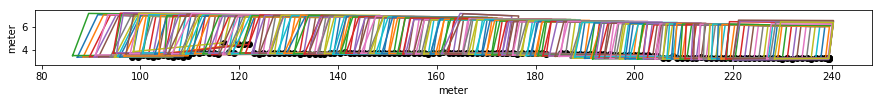

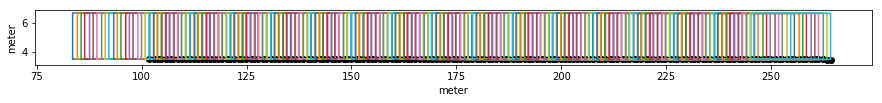

ID: 78261 Valid/total timestamps: 157 / 96 score: 0.13703888927147895 runtime: 2.33654522895813 
 width: 2.207095702417653 length: 3.4436236280035217


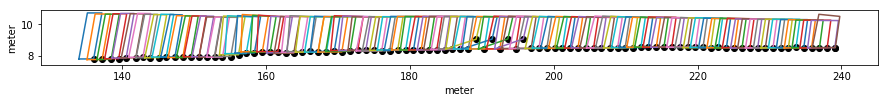

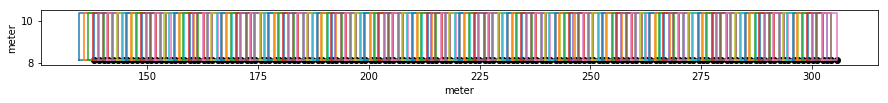

ID: 80261 Valid/total timestamps: 148 / 81 score: 0.26082207076435676 runtime: 2.0951805114746094 
 width: 1.9912268867201304 length: 3.16354041777937


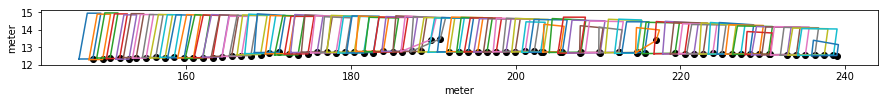

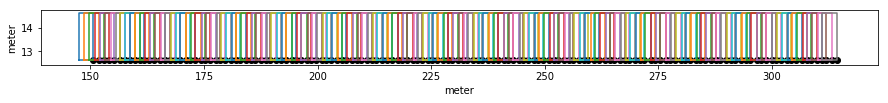

ID: 83261 Valid/total timestamps: 84 / 81 score: 0.2368315981020602 runtime: 0.8542914390563965 
 width: 2.096293344840503 length: 3.6969680258300968


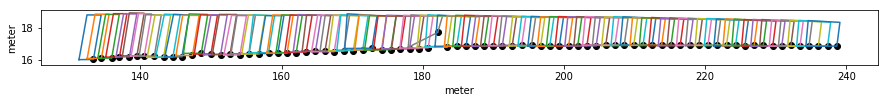

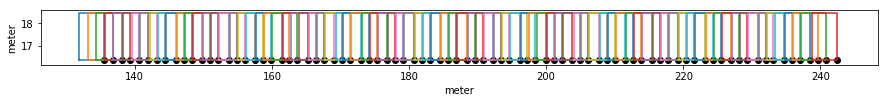

ID: 86261 Valid/total timestamps: 192 / 171 score: 0.3929516030377828 runtime: 3.4532337188720703 
 width: 3.991303437915638 length: 20.614318401533477


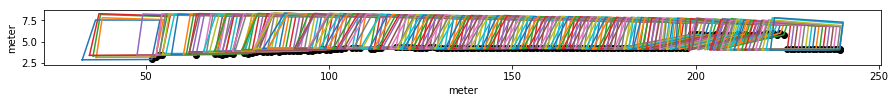

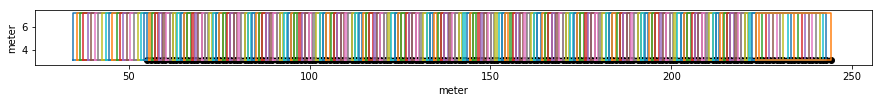

ID: 87261 Valid/total timestamps: 86 / 17 score: 36.37321147348356 runtime: 0.9464311599731445 
 width: 1.9968313195077076 length: 4.288621177235979


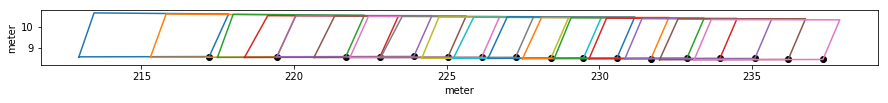

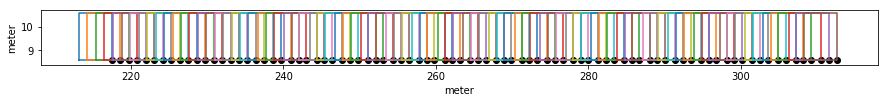

ID: 89261 Valid/total timestamps: 160 / 157 score: 0.13186042054877523 runtime: 5.637524604797363 
 width: 3.071559020538133 length: 11.99006369267903


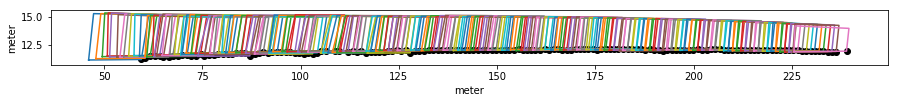

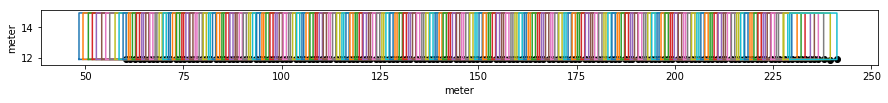

ID: 93261 Valid/total timestamps: 162 / 93 score: 0.24090543674618448 runtime: 3.3059985637664795 
 width: 2.4802788288554187 length: 4.7276252318875915


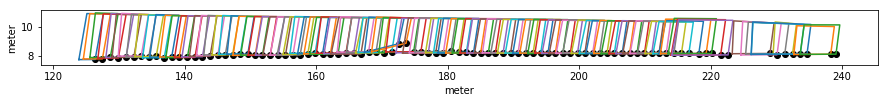

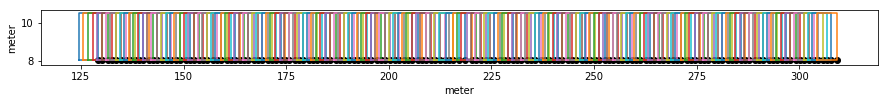

ID: 96261 Valid/total timestamps: 72 / 66 score: 0.37442749168181655 runtime: 1.1447405815124512 
 width: 2.334973899177776 length: 2.1974090824807986


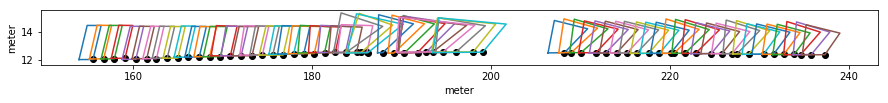

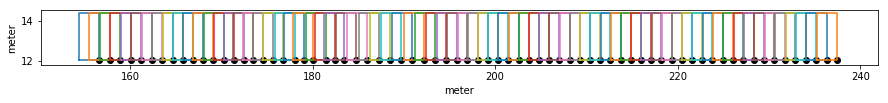

ID: 98261 Valid/total timestamps: 127 / 70 score: 0.2093773877147703 runtime: 2.225377082824707 
 width: 2.1604870417037363 length: 3.9337101289602887


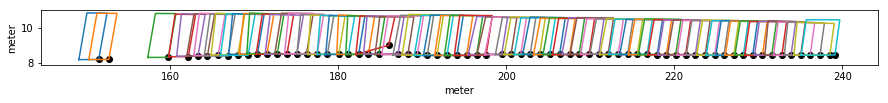

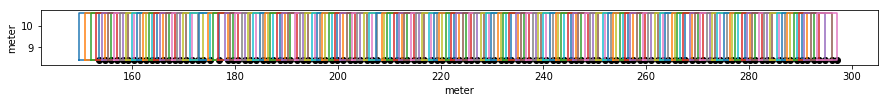

ID: 100261 Valid/total timestamps: 79 / 66 score: 0.24935522071219038 runtime: 4.303517818450928 
 width: 2.2803839030839694 length: 4.207044876467943


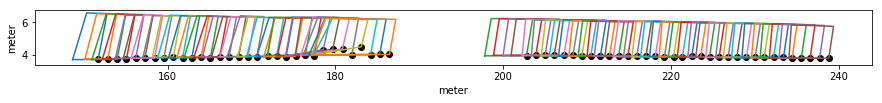

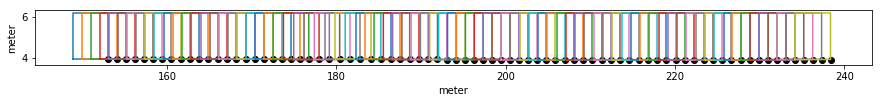

ID: 102261 Valid/total timestamps: 138 / 62 score: 1.414382994894608 runtime: 1.9539666175842285 
 width: 2.1128417218566016 length: 4.946830348636929


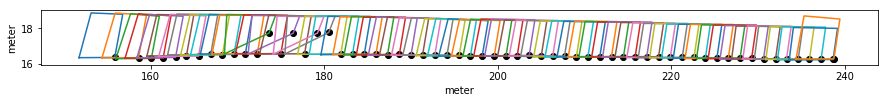

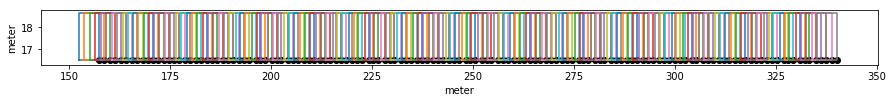

ID: 105261 Valid/total timestamps: 119 / 70 score: 0.5235064144185165 runtime: 1.7797071933746338 
 width: 2.002537318781461 length: 3.9369625597978857


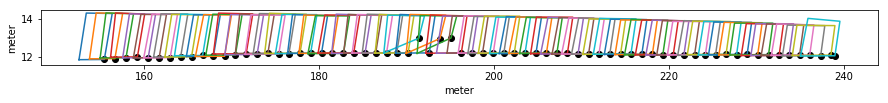

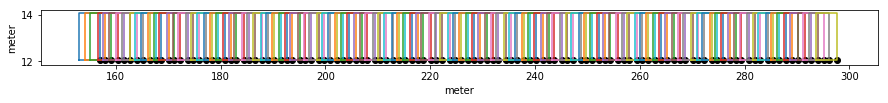

ID: 109261 Valid/total timestamps: 134 / 91 score: 0.1983462543046886 runtime: 5.8939244747161865 
 width: 2.3007112214257717 length: 3.3652444184641808


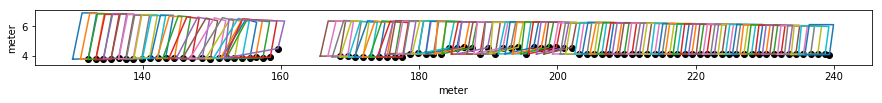

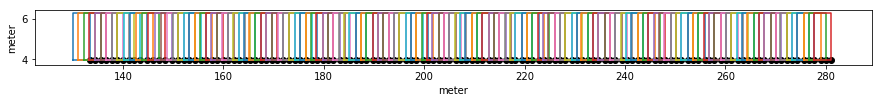

ID: 118261 Valid/total timestamps: 152 / 107 score: 0.15337643857558275 runtime: 4.752198696136475 
 width: 2.438299075772971 length: 4.182396613133565


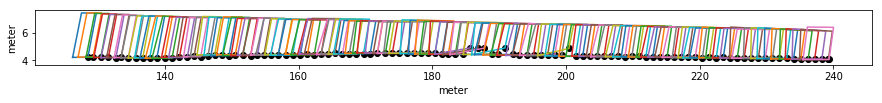

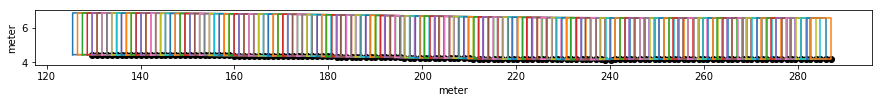

ID: 120261 Valid/total timestamps: 119 / 59 score: 0.9004842355910844 runtime: 1.3560504913330078 
 width: 2.011634607913412 length: 3.6163374801523496


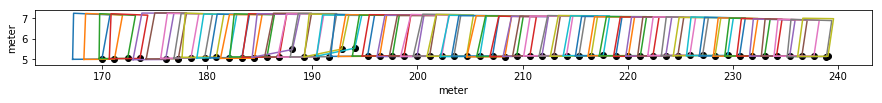

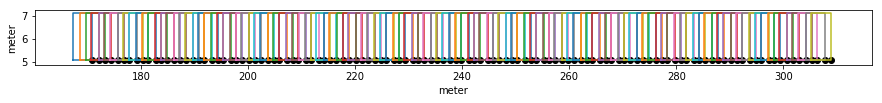

ID: 123261 Valid/total timestamps: 81 / 47 score: 1.4459565289299288 runtime: 0.7461278438568115 
 width: 2.0899549637182515 length: 4.091639113905223


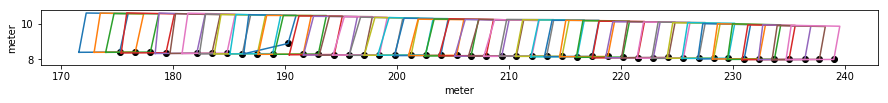

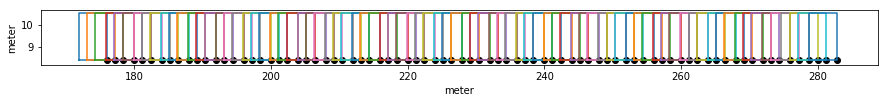

ID: 124261 Valid/total timestamps: 122 / 70 score: 0.87995591842762 runtime: 1.4341824054718018 
 width: 1.889207112092588 length: 3.942996146353529


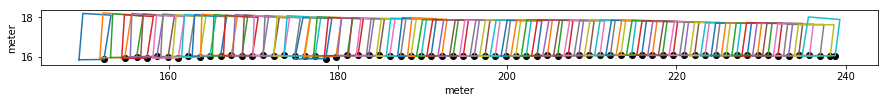

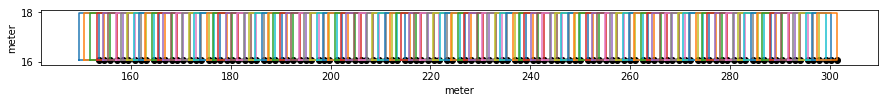

ID: 129261 Valid/total timestamps: 106 / 69 score: 0.12764515801923004 runtime: 3.672565460205078 
 width: 2.0020331435924605 length: 3.207523109191354


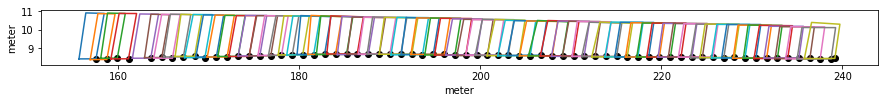

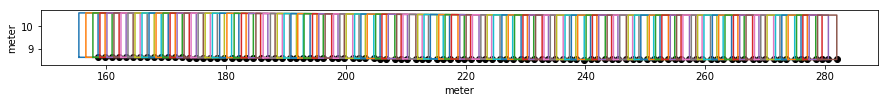

ID: 130261 Valid/total timestamps: 131 / 82 score: 0.11211640834802103 runtime: 4.110226392745972 
 width: 2.252554922598978 length: 4.104956267980705


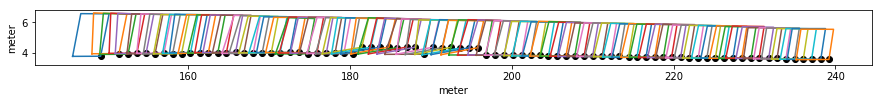

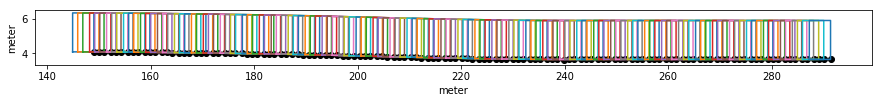

ID: 136261 Valid/total timestamps: 131 / 86 score: 0.17283212378815538 runtime: 1.5703742504119873 
 width: 2.1328789829795607 length: 4.061542933224077


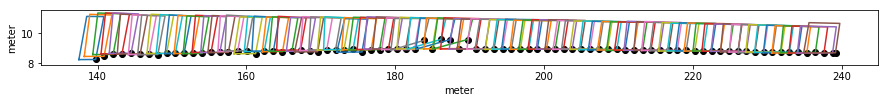

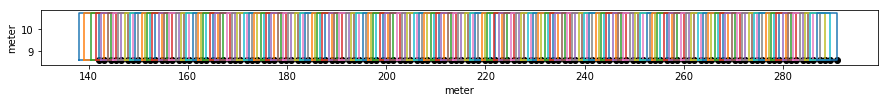

ID: 138261 Valid/total timestamps: 127 / 86 score: 0.12811358672135945 runtime: 4.016087293624878 
 width: 2.247500004147468 length: 3.2588213764889584


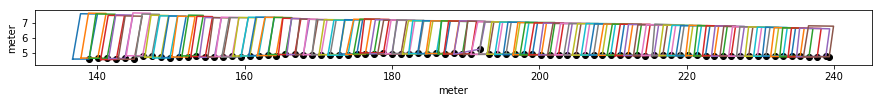

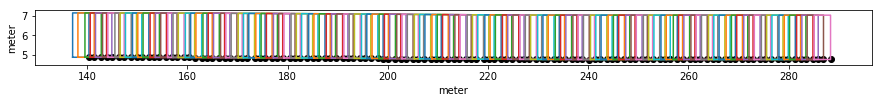

ID: 139261 Valid/total timestamps: 81 / 70 score: 2.9680585198184155 runtime: 0.7932112216949463 
 width: 2.2647557205801525 length: 6.276944937718326


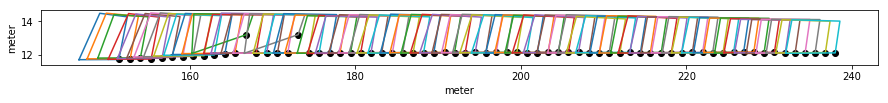

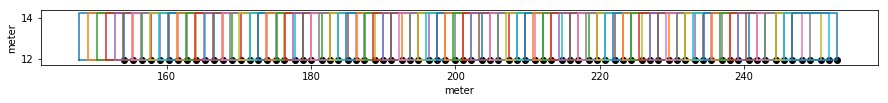

ID: 143261 Valid/total timestamps: 156 / 88 score: 0.10237488201715948 runtime: 4.661059379577637 
 width: 2.3015409584313606 length: 5.749529571042516


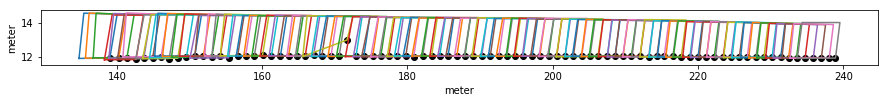

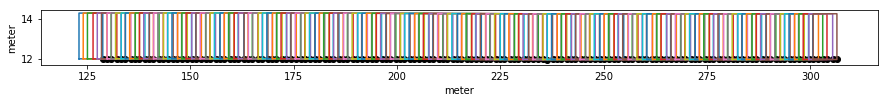

ID: 147261 Valid/total timestamps: 110 / 86 score: 0.10423727282146779 runtime: 3.8067679405212402 
 width: 2.0922023467037807 length: 4.309263283547146


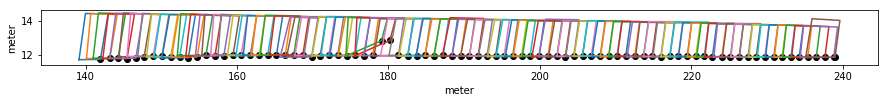

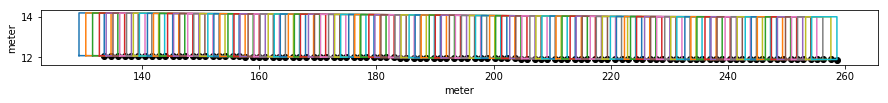

ID: 148261 Valid/total timestamps: 157 / 92 score: 0.15352403505396967 runtime: 5.0997231006622314 
 width: 2.2047653066594406 length: 4.30474998662787


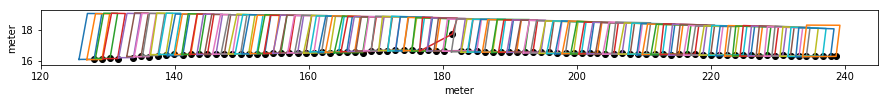

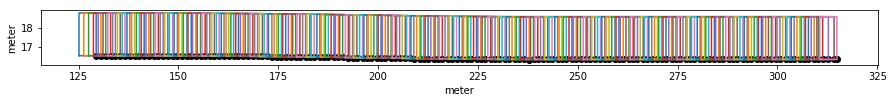

ID: 150261 Valid/total timestamps: 89 / 71 score: 0.10940069336768429 runtime: 4.283474683761597 
 width: 1.994888744725672 length: 4.57664561732319


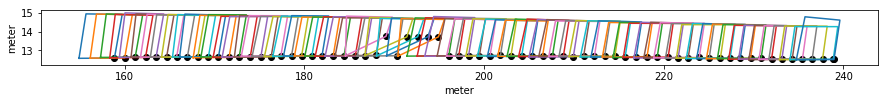

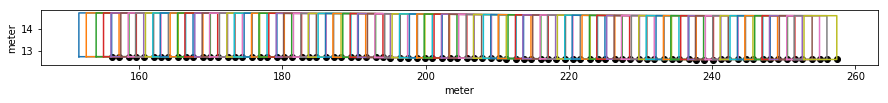

ID: 155261 Valid/total timestamps: 123 / 77 score: 1.6243287250307368 runtime: 1.5933620929718018 
 width: 2.188301026273049 length: 4.184136232341789


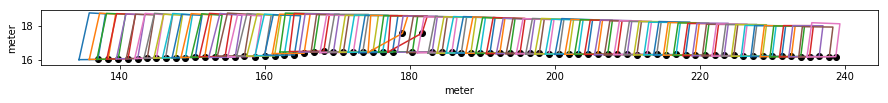

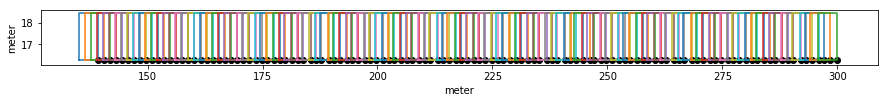

ID: 156261 Valid/total timestamps: 182 / 110 score: 0.39288061671523833 runtime: 5.289998531341553 
 width: 3.175431100237393 length: 23.873396530437674


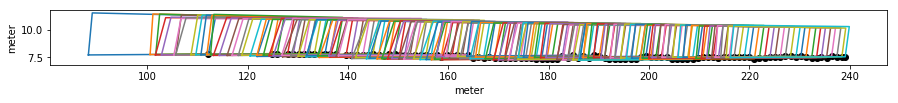

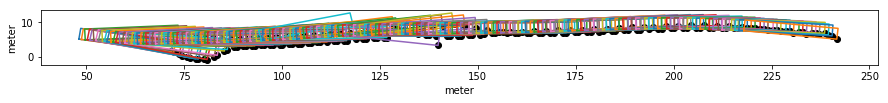

ID: 157261 Valid/total timestamps: 116 / 84 score: 0.1443025754725465 runtime: 4.081183433532715 
 width: 2.217903184930344 length: 4.445980424539693


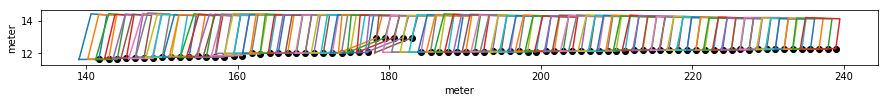

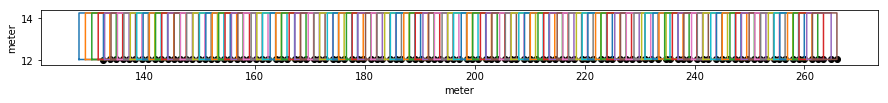

ID: 158261 Valid/total timestamps: 107 / 75 score: 0.16422752265294205 runtime: 3.651535987854004 
 width: 2.1171259513334797 length: 4.173051170580759


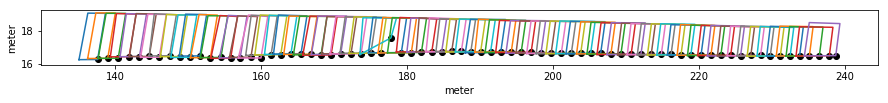

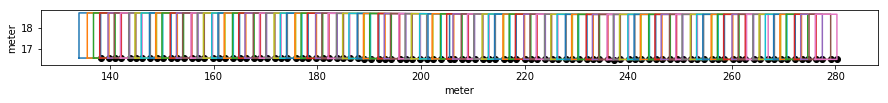

ID: 159261 Valid/total timestamps: 146 / 73 score: 2.8297439206390327 runtime: 1.83076810836792 
 width: 2.0985498764140607 length: 4.233053021423631


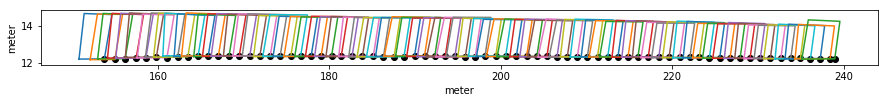

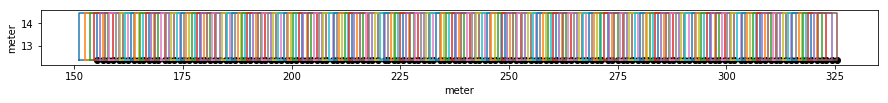

ID: 161261 Valid/total timestamps: 115 / 89 score: 0.16149175929253737 runtime: 3.9219422340393066 
 width: 2.6587841543438966 length: 7.538814697569027


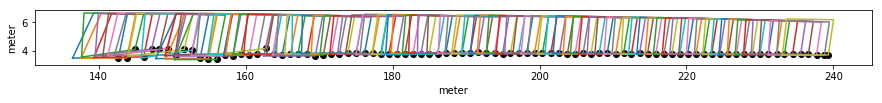

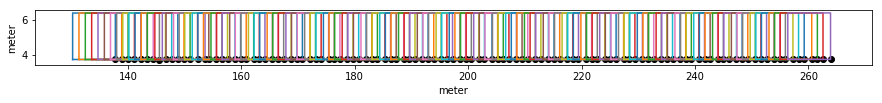

ID: 165261 Valid/total timestamps: 188 / 148 score: 0.17050734404902573 runtime: 5.539394855499268 
 width: 3.260528439130815 length: 23.065873786936905


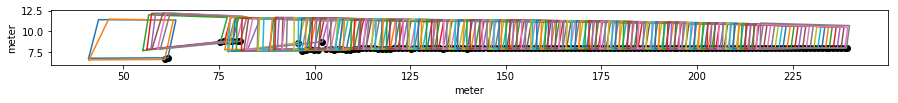

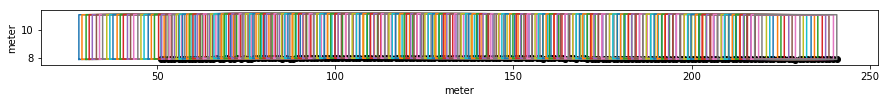

ID: 167261 Valid/total timestamps: 88 / 88 score: 0.15210193760444599 runtime: 3.1668007373809814 
 width: 2.0767584654354736 length: 3.2554519794117165


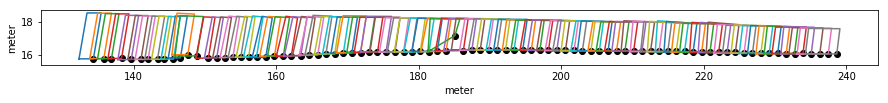

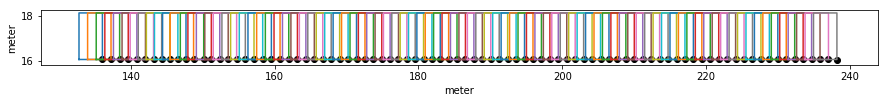

ID: 172261 Valid/total timestamps: 183 / 122 score: 0.11888949828707505 runtime: 5.4702839851379395 
 width: 2.4389553892534637 length: 2.960418993829671


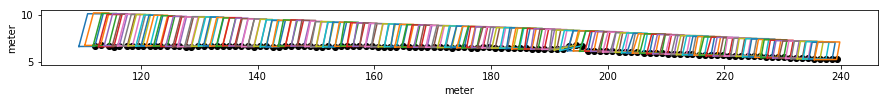

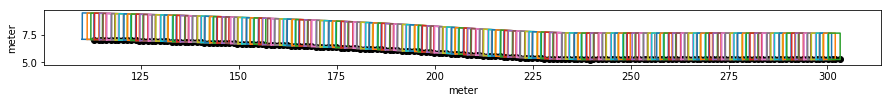

C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils_optimization.py:126: RuntimeWarning: invalid value encountered in true_divide
  omega = np.diff(theta)/dt[:-1]
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils_optimization.py:126: RuntimeWarning: divide by zero encountered in true_divide
  omega = np.diff(theta)/dt[:-1]
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils_optimization.py:173: RuntimeWarning: invalid value encountered in true_divide
  omega = np.diff(theta)/dt[:-1]


ID: 175261 Valid/total timestamps: 188 / 104 score: 0.17026868587791796 runtime: 2.917423725128174 
 width: 2.4436651631705955 length: 3.3966563430039027


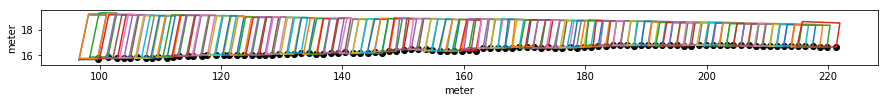

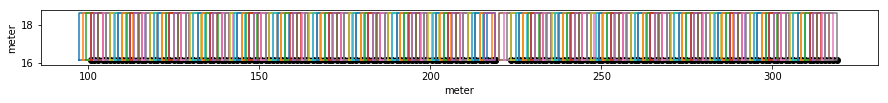

ID: 176261 Valid/total timestamps: 93 / 77 score: 0.1801530699171256 runtime: 3.4301986694335938 
 width: 2.4024071964680145 length: 5.073766439441431


C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils_optimization.py:173: RuntimeWarning: divide by zero encountered in true_divide
  omega = np.diff(theta)/dt[:-1]


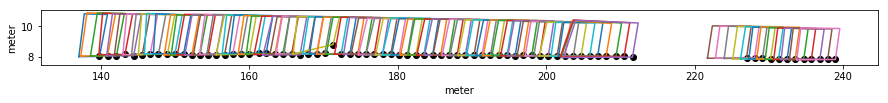

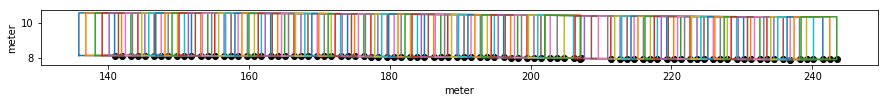

ID: 181261 Valid/total timestamps: 124 / 67 score: 0.17889587318423722 runtime: 4.059149980545044 
 width: 2.208298778104613 length: 4.925659803979018


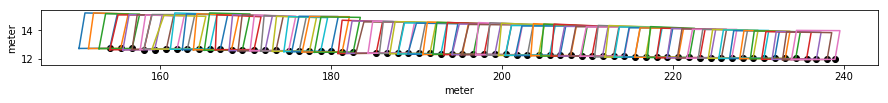

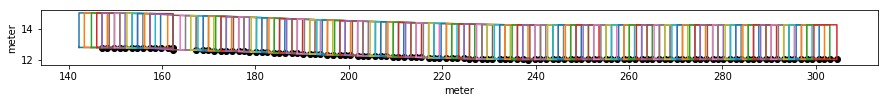

ID: 184261 Valid/total timestamps: 95 / 48 score: 0.5317511539951095 runtime: 0.9274001121520996 
 width: 2.0051861284084977 length: 3.750986524896866


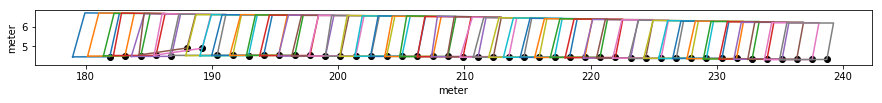

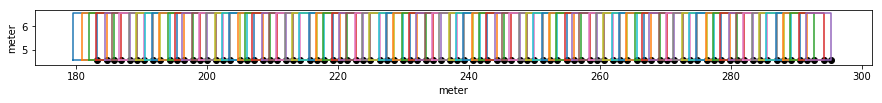

ID: 187261 Valid/total timestamps: 67 / 63 score: 0.09779147035876337 runtime: 2.1893117427825928 
 width: 2.3608897314889186 length: 7.152907494681843


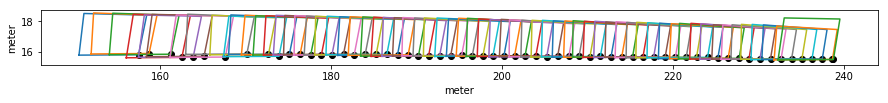

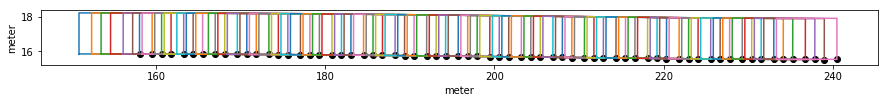

ID: 193261 Valid/total timestamps: 66 / 66 score: 0.1842976183584088 runtime: 0.5558526515960693 
 width: 2.0283812622315023 length: 3.2102383943632673


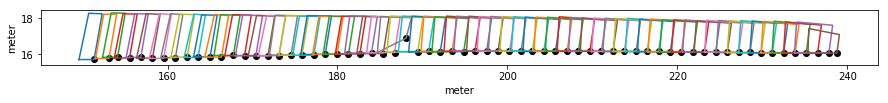

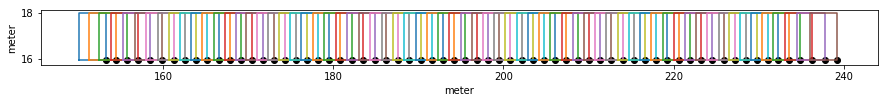

ID: 197221 Valid/total timestamps: 88 / 78 score: 0.1233658645406775 runtime: 3.272960662841797 
 width: 2.219232861506478 length: 5.2977434872568345


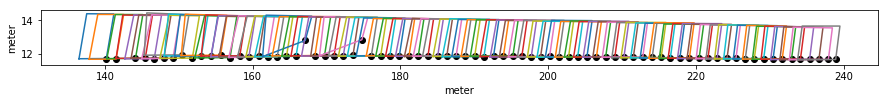

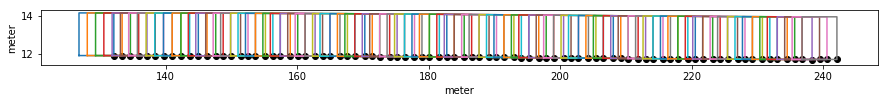

ID: 197261 Valid/total timestamps: 130 / 69 score: 1.7464178664474856 runtime: 1.552347183227539 
 width: 2.0586551257816246 length: 4.4006260762227445


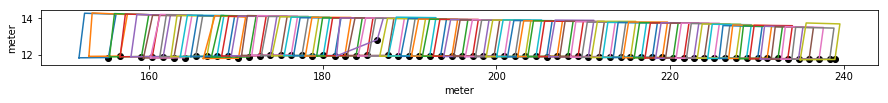

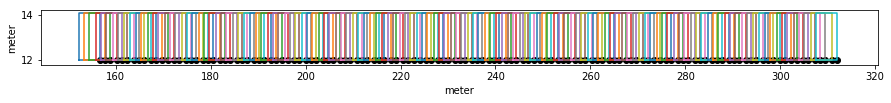

ID: 202261 Valid/total timestamps: 134 / 76 score: 0.13186523416111 runtime: 4.979541301727295 
 width: 2.110706055181193 length: 3.916156749622695


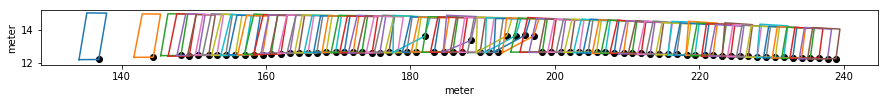

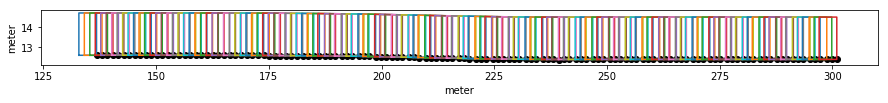

ID: 205261 Valid/total timestamps: 121 / 82 score: 0.11303113276173349 runtime: 3.9710042476654053 
 width: 2.3412049250568416 length: 5.43312777664545


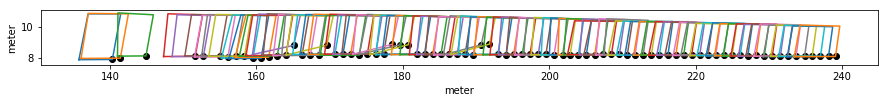

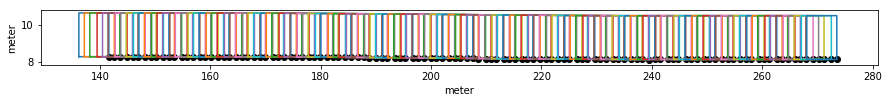

ID: 208261 Valid/total timestamps: 130 / 82 score: 0.13169796393625208 runtime: 4.199347734451294 
 width: 1.867875426734458 length: 3.1743589874610905


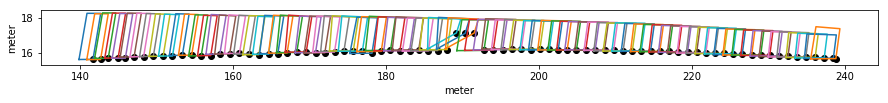

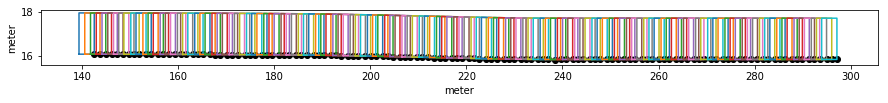

ID: 209261 Valid/total timestamps: 127 / 74 score: 0.5057267768826326 runtime: 1.5183079242706299 
 width: 2.3318394628815216 length: 4.230727645168933


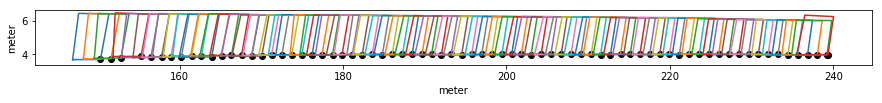

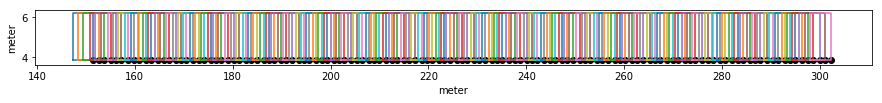

ID: 214261 Valid/total timestamps: 92 / 78 score: 0.21691430037175344 runtime: 3.414175033569336 
 width: 2.0015494149245034 length: 3.3238834997152553


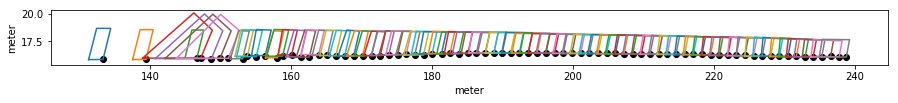

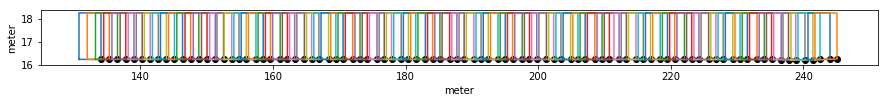

ID: 215261 Valid/total timestamps: 93 / 80 score: 0.12427877681284685 runtime: 3.6585302352905273 
 width: 2.254953619288206 length: 4.768485612435824


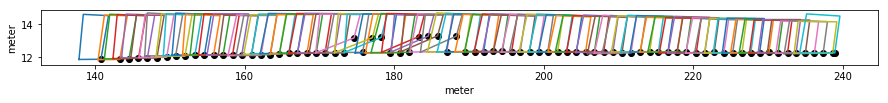

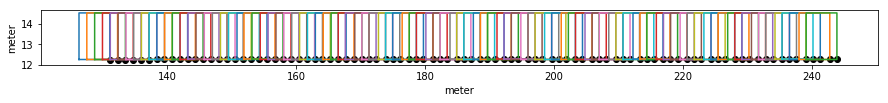

ID: 218261 Valid/total timestamps: 140 / 73 score: 0.5915323395396136 runtime: 1.96097731590271 
 width: 1.9700041255843297 length: 3.8791148723857893


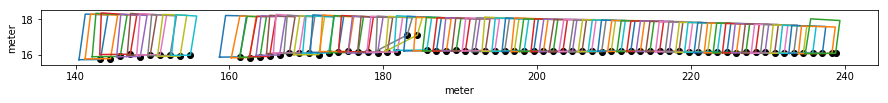

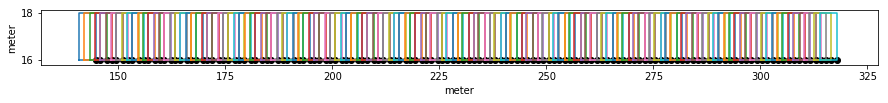

ID: 221261 Valid/total timestamps: 165 / 161 score: 0.3291100636579202 runtime: 5.026600360870361 
 width: 3.482307341020219 length: 23.91405083601025


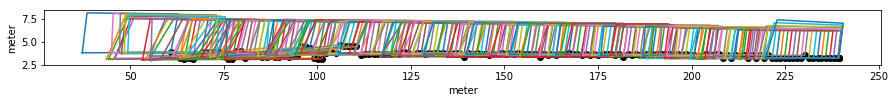

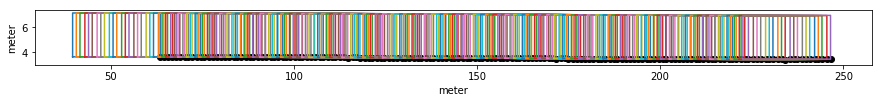

ID: 227261 Valid/total timestamps: 101 / 72 score: 0.10753282604253891 runtime: 3.6585466861724854 
 width: 2.071658973489985 length: 3.72722582775197


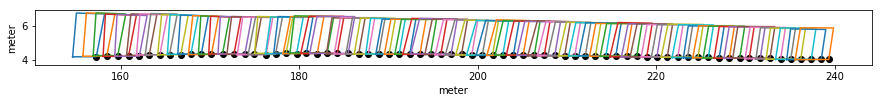

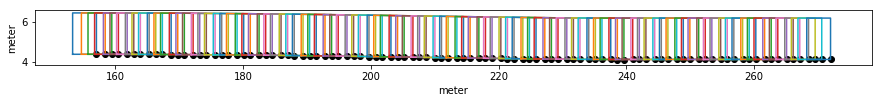

ID: 230261 Valid/total timestamps: 139 / 71 score: 0.09934221317994715 runtime: 4.264460802078247 
 width: 2.0151879005341287 length: 4.424159049192324


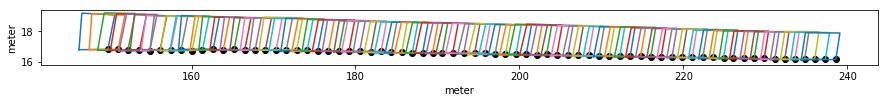

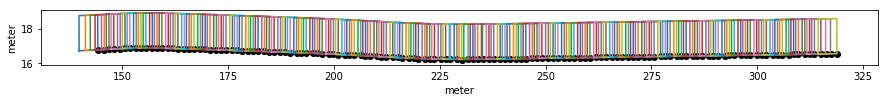

ID: 241261 Valid/total timestamps: 114 / 97 score: 0.09898737712994672 runtime: 3.8047592639923096 
 width: 2.141334204474054 length: 3.4739703404226723


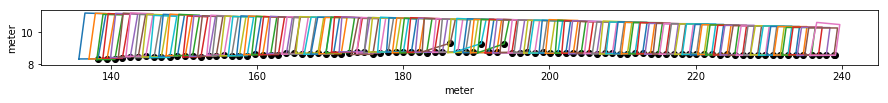

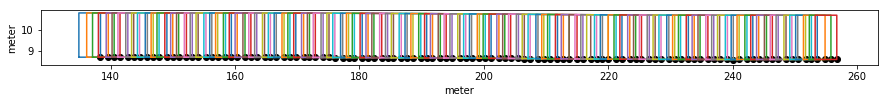

ID: 250261 Valid/total timestamps: 123 / 80 score: 0.4816906250410312 runtime: 1.4131495952606201 
 width: 2.2559004766688213 length: 4.89138116292316


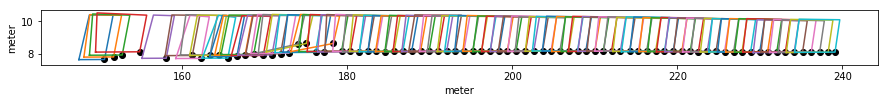

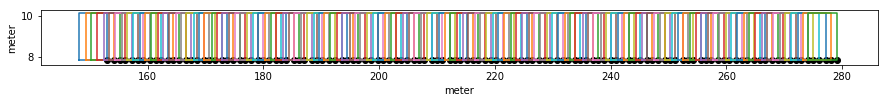

ID: 263221 Valid/total timestamps: 111 / 86 score: 0.2136368433175384 runtime: 3.7156178951263428 
 width: 3.541341254237433 length: 22.62763269371104


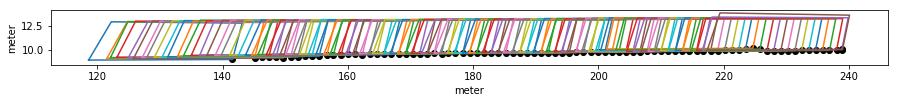

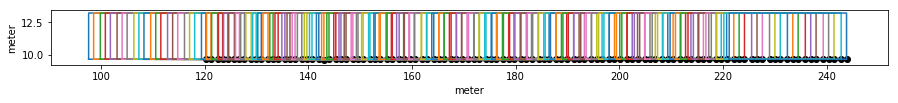

ID: 264221 Valid/total timestamps: 118 / 95 score: 0.5889508100124435 runtime: 4.055146217346191 
 width: 3.6029767078458335 length: 22.98419100511835


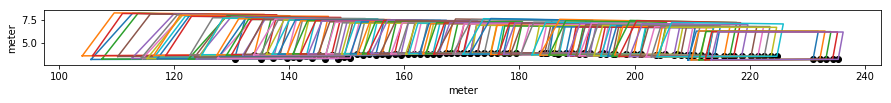

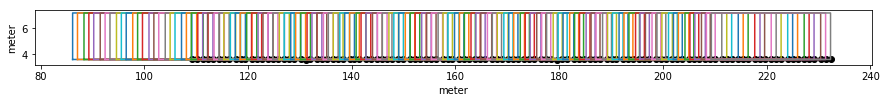

ID: 270211 Valid/total timestamps: 27 / 26 score: 0.22008870002108188 runtime: 0.20531058311462402 
 width: 2.434424494777316 length: 2.681196616747767


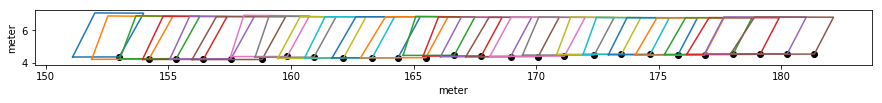

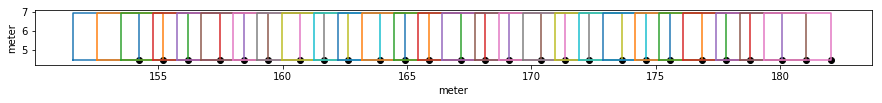

ID: 273211 Valid/total timestamps: 26 / 24 score: 0.42012336343616413 runtime: 0.19530940055847168 
 width: 2.867310521401898 length: 2.848915914743781


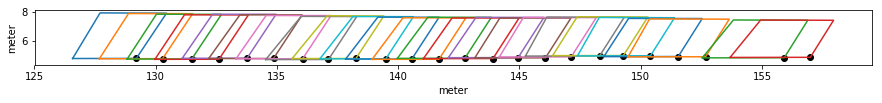

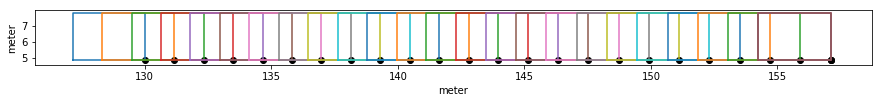

ID: 312261 Valid/total timestamps: 174 / 163 score: 0.29366510955375436 runtime: 5.103717088699341 
 width: 3.311258478995696 length: 21.02294542627861


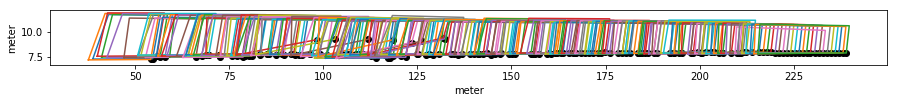

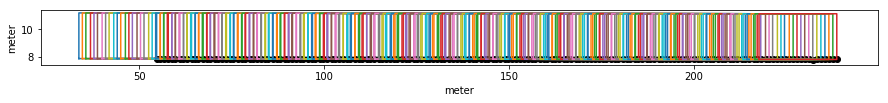

IndexError: index -1 is out of bounds for axis 0 with size 0

In [50]:
import utils_optimization as opt
importlib.reload(opt)
# group by objects

groups = df.groupby('ID')
groupList = list(groups.groups)
nO = len(groupList) # number of cars to test
print(nO,'unique cars')
# optimization parameters
lam1 = 1 # modification of measurement
lam2 = 1 # acceleration
lam3 = 0 # jerk
lam4 = 10 # theta
lam5 = 1 # omega

score = np.zeros(nO) # record correction score

for i in range(nO):
    ID = groupList[i]
    Y1 = groups.get_group(ID)
    
    # impute missing timestamps
    timestamps = Y1['Timestamp'].values
    nans, x= utils.nan_helper(timestamps)
    timestamps[nans]= np.interp(x(nans), x(~nans), timestamps[~nans])
    dt = np.diff(timestamps)

    # get bottom 4 points coordinates
    Y1gps = np.array(Y1[['bbrlat','bbrlon','fbrlat','fbrlon','fbllat','fbllon','bbllat','bbllon']])
    Y1 = np.array(Y1[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
    
    if len(Y1)<2:
        continue
        
    # Euler forward dynamics
    start = time.time()
    N = len(Y1) 
    notNan = ~np.isnan(np.sum(Y1,axis=-1))
    Y1 = Y1[notNan,:]
    a0 = np.zeros((N))
    theta0 = np.zeros((N))
    v0 = (Y1[-1,0]-Y1[0,0])/(timestamps[notNan][-1]-timestamps[notNan][0])
    x0 = (Y1[0,0]+Y1[0,6])/2
    y0 = (Y1[0,1]+Y1[0,7])/2
    X0 = np.concatenate((a0.T, theta0.T, \
                         [v0,x0,y0,np.nanmean(np.abs(Y1[:,1]-Y1[:,7])),\
                          np.nanmean(np.abs(Y1[:,0]-Y1[:,2]))]),axis=-1)
    bnds = [(-5,5) for i in range(0,N)]+\
        [(-np.pi/8,np.pi/8) for i in range(N)]+\
        [(0,40),(-np.inf,np.inf),(0,np.inf),(1,4),(2,np.inf)]

    # Constraints definition (only for COBYLA, SLSQP and trust-constr)
    res = minimize(opt.obj1, X0, (Y1,N,dt,notNan,lam1,lam2,lam3,lam4,lam5), method = 'L-BFGS-B',
                    bounds=bnds, options={'disp': False,'maxiter':100000})#
    end = time.time()
    # extract results
    Yre, x,y,v,a,theta,omega,w,l = opt.unpack1(res,N,dt)
    score[i] = LA.norm(Y1-Yre[notNan,:],'fro')/np.count_nonzero(notNan)
    print('ID:',ID, 'Valid/total timestamps:',N, '/',np.count_nonzero(notNan),'score:',score[i],\
          'runtime:',end - start,'\n width:',w,'length:',l) 
    # plot 
    D = Y1
    fig, ax = plt.subplots(figsize=(15,1))

    for i in range(len(D)):
        coord = D[i,:]
        coord = np.reshape(coord,(-1,2)).tolist()
        coord.append(coord[0]) #repeat the first point to create a 'closed loop'
        xs, ys = zip(*coord) #lon, lat as x, y
        plt.plot(xs,ys)
    plt.scatter(D[:,2],D[:,3],color='black')
    ax = plt.gca()
    plt.xlabel('meter')
    plt.ylabel('meter')
    ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
    plt.show() 

    D = Yre
    fig, ax = plt.subplots(figsize=(15,1))
    for i in range(len(D)):
        coord = D[i,:]
        coord = np.reshape(coord,(-1,2)).tolist()
        coord.append(coord[0]) #repeat the first point to create a 'closed loop'
        xs, ys = zip(*coord) #lon, lat as x, y
        plt.plot(xs,ys)
    plt.scatter(D[:,2],D[:,3],color='black')
    ax = plt.gca()
    plt.xlabel('meter')
    plt.ylabel('meter')
    ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
    plt.show() 

In [60]:
import utils_optimization as opt
importlib.reload(opt)
import utils
importlib.reload(utils)
# optimization parameters
lam1 = 1 # modification of measurement
lam2 = 1 # acceleration
lam3 = 0 # jerk
lam4 = 10 # theta
lam5 = 1 # omega
ID = 22261 
Y1 = groups.get_group(ID)
print(len(Y1))
print(Y1['bbr_x'])
timestamps = Y1['Timestamp'].values
# nans, x= utils.nan_helper_orig(timestamps)
# timestamps[nans]= np.interp(x(nans), x(~nans), timestamps[~nans])
timestamps= utils.nan_helper(timestamps)
dt = np.diff(timestamps)
print(dt)
# get bottom 4 points coordinates
Y1gps = np.array(Y1[['bbrlat','bbrlon','fbrlat','fbrlon','fbllat','fbllon','bbllat','bbllon']])
Y1 = np.array(Y1[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])

# Euler forward dynamics
start = time.time()
N = len(Y1) 
notNan = ~np.isnan(np.sum(Y1,axis=-1))
Y1 = Y1[notNan,:]
a0 = np.zeros((N))
theta0 = np.zeros((N))
v0 = (Y1[-1,0]-Y1[0,0])/(timestamps[notNan][-1]-timestamps[notNan][0])
x0 = (Y1[0,0]+Y1[0,6])/2
y0 = (Y1[0,1]+Y1[0,7])/2
X0 = np.concatenate((a0.T, theta0.T, \
                     [v0,x0,y0,np.nanmean(np.abs(Y1[:,1]-Y1[:,7])),\
                      np.nanmean(np.abs(Y1[:,0]-Y1[:,2]))]),axis=-1)
bnds = [(-5,5) for i in range(0,N)]+\
    [(-np.pi/8,np.pi/8) for i in range(N)]+\
    [(0,40),(-np.inf,np.inf),(0,np.inf),(1,4),(2,np.inf)]

# Constraints definition (only for COBYLA, SLSQP and trust-constr)
res = minimize(opt.obj1, X0, (Y1,N,dt,notNan,lam1,lam2,lam3,lam4,lam5), method = 'L-BFGS-B',
                bounds=bnds, options={'disp': False,'maxiter':100000})#
end = time.time()
# extract results
Yre, x,y,v,a,theta,omega,w,l = opt.unpack1(res,N,dt)
print('ID:',ID, 'N:',N, 'runtime:',end - start,'\n width:',w,'length:',l)


119
7             NaN
15            NaN
23            NaN
31            NaN
38     169.719018
          ...    
926           NaN
936           NaN
946           NaN
956           NaN
966           NaN
Name: bbr_x, Length: 119, dtype: float64
[0.03700733 0.03336787 0.03336787 0.03336787 0.03336787 0.03336811
 0.03336787 0.03278518 0.03395057 0.03336787 0.03336787 0.03336787
 0.03336787 0.03336787 0.03336787 0.03584218 0.0308938  0.02910614
 0.03999996 0.02999997 0.03000021 0.03999996 0.02999997 0.02999997
 0.03999996 0.02999997 0.02999997 0.0400002  0.02999997 0.02999997
 0.03999996 0.02999997 0.02999997 0.03999996 0.02999997 0.03000021
 0.03999996 0.02999997 0.03999996 0.02999997 0.02999997 0.03999996
 0.03000021 0.02999997 0.03999996 0.02999997 0.02999997 0.03999996
 0.02999997 0.02999997 0.0400002  0.02999997 0.02999997 0.03999996
 0.02999997 0.02999997 0.03999996 0.03000021 0.02999997 0.03999996
 0.02999997 0.02999997 0.03999996 0.02999997 0.02999997 0.0400002
 0.02999997 0.0299999

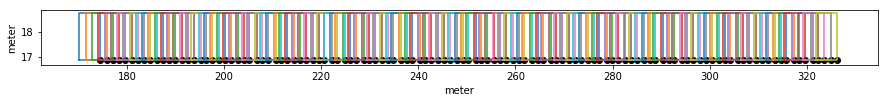

In [56]:
# plot 
D = Yre
fig, ax = plt.subplots(figsize=(15,1))

for i in range(len(D)):
    coord = D[i,:]
    coord = np.reshape(coord,(-1,2)).tolist()
    coord.append(coord[0]) #repeat the first point to create a 'closed loop'
    xs, ys = zip(*coord) #lon, lat as x, y
    plt.plot(xs,ys)

plt.scatter(D[:,2],D[:,3],color='black')
#     plt.scatter(D[:,0],D[:,1],color='blue') # bbr
# plt.scatter(D[:,4],D[:,5],color='red') # fbl
ax = plt.gca()
plt.xlabel('meter')
plt.ylabel('meter')
ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
plt.show() 

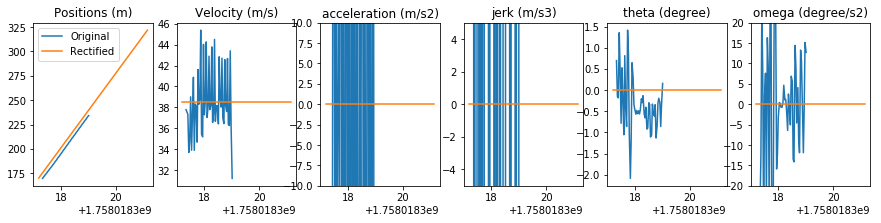

In [59]:
import utils
importlib.reload(utils)
# cx = (Y1[:,0]+Y1[:,6])/2
# cy = (Y1[:,1]+Y1[:,7])/2

fig, (ax1, ax2, ax3, ax4, ax5,ax6) = plt.subplots(1, 6, figsize=(15,3))

ax1.plot(timestamps[notNan], Y1[:,0], label='Original')
ax1.plot(timestamps, Yre[:,0] , label='Rectified')
ax1.legend()
ax1.set_title('Positions (m)')
    
_,_,v1 = utils.calc_vel(Y1, timestamps[notNan])
# _,_,vre = utils.calc_vel(Yre,timestamps)
# v1 = np.diff(Y1[:,0], append=Y1[-1,0])
# vre = np.diff(Yre[:,0], append=Yre[-1,0])
ax2.plot(timestamps[notNan], v1, label='Original velocity')
ax2.plot(timestamps, v , label='Rectified velocity')
ax2.set_title('Velocity (m/s)')

a1 = utils.calc_accel(Y1[:,0], timestamps[notNan])
# are = utils.calc_accel(Yre[:,0],timestamps)
# a1 = np.diff(v1, append=v1[-1])
# are = np.diff(vre, append=vre[-1])
ax3.plot(timestamps[notNan], a1, label='Original accel')
ax3.plot(timestamps, a , label='Rectified accel')
ax3.set_title('acceleration (m/s2)')
ax3.set_ylim([-10,10])

# j1 = np.diff(a1, append=a1[-1])
# jre = np.diff(are, append=are[-1])
j1 = np.gradient(a1,timestamps[notNan])
jre = np.gradient(a, timestamps)
ax4.plot(timestamps[notNan], j1)
ax4.plot(timestamps, jre)
ax4.set_title('jerk (m/s3)')
ax4.set_ylim([-5,5])

theta1 = utils.calc_theta(Y1, timestamps[notNan])
# thetare = utils.calc_theta(Yre,timestamps)
ax5.plot(timestamps[notNan], np.degrees(theta1))
ax5.plot(timestamps, np.degrees(theta))
ax5.set_title('theta (degree)')

thetaddot1 = np.gradient(theta1,timestamps[notNan])
# thetaddotre = np.gradient(np.gradient(thetare)/dt)/dt
# theta1 = np.diff(a1, append=a1[-1])
# jre = np.diff(are, append=are[-1])
ax6.plot(timestamps[notNan], np.degrees(thetaddot1))
ax6.plot(timestamps, np.degrees(omega))
ax6.set_title('omega (degree/s2)')
ax6.set_ylim([-20,20])
plt.show()

In [190]:
AB = np.array([A,B])
lats = AB[:,0]
lngs = AB[:,1]
utils.draw_map_box(Y1gps[20:40],Y1gps[0,0],Y1gps[0,1], 30, lats, lngs)


###############################

 Beginning Key Insertion ...

Key Insertion Completed!!


In [7]:
# least squares formulation just about the same run time and results
# try calculating the gradient of objective function
# optimize on the road plane
# a formulation that accounts for heading change (for lane changing)
# try having simplified decision variables and no constraints


start = time.time()


p_dim = 2  # lp norm
p = 1

dt = np.gradient(timestamps)
lam1 = 1
lam2 = 0 # regularize acceleration 100
lam3 = 10 # regularize jerk
lam4 = 100 # regularize on thetaddot
lam5 = 100
N = len(Y1)
global lam1, lam2, lam3, lam4, dt, Y1, timestamps, N

def obj(X):
    """The cost function
        X = [cx, cy, theta, w, l]^T
    """    
    cx = X[:N]
    cy = X[N:2*N]
    theta = X[2*N:3*N]
    w = X[3*N]
    l = X[3*N+1]
    
    # compute positions
    xa = cx + w/2*sin(theta)
    ya = cy - w/2*cos(theta)
    xb = xa + l*cos(theta)
    yb = ya + l*sin(theta)
    xc = xb - w*sin(theta)
    yc = yb + w*cos(theta)
    xd = xa - w*sin(theta)
    yd = ya + w*cos(theta)
    Yre = np.stack([xa,ya,xb,yb,xc,yc,xd,yd],axis=-1) 
    
    # min perturbation
    c1 = lam1*np.sum((Y1-Yre)**2)
    
#     # jerk regularization
#     v = np.gradient(cx,timestamps)/cos(theta)
#     a = np.gradient(v,timestamps)
#     j = np.gradient(a,timestamps)
#     c3 = lam3 * np.sum(j**2)

#     # theta ddot regularization
#     thetaddot = np.gradient(np.gradient(theta)/dt)/dt
#     c4 = lam4 * np.sum(thetaddot**2)
# #     print(c1,c3,c4)

#     # pfaffian constraint
#     vx = np.gradient(cx)/dt
#     vy = np.gradient(cy)/dt
#     c5 = lam5*np.sum((-vx*sin(theta)+vy*cos(theta))**2)
#     print(c1,c3,c4,c5)
    return c1 

def const5(X):
    # Pfaffian constraint
    cx = X[:N]
    cy = X[N:2*N]
    theta = X[2*N:3*N]

    vx = np.gradient(cx)/dt
    vy = np.gradient(cy)/dt
    return -vx*sin(theta)+vy*cos(theta)
    
#     return np.sum(c5**2)
nlc = ({"type": "eq", "fun": const5})
# initial values
cx0 = (Y1[:,0]+Y1[:,6])/2
cy0 = (Y1[:,1]+Y1[:,7])/2
w0 = 1
l0 = 4
theta0 = np.zeros((N))
X0 = np.concatenate((cx0.T, cy0.T, theta0, [w0,l0]), axis=0)
bnds = [(0,np.inf) for i in range(0,2*N)]+[(-np.pi/8,np.pi/8) for i in range(len(theta0))]+[(1,4),(2,50)]
list1, list2 = zip(*bnds)
bnd_list = (list(list1),list(list2))

# Constraints definition (only for COBYLA, SLSQP and trust-constr)
res = minimize(obj, X0, method = 'L-BFGS-B',
                bounds=bnds, options={'disp': False,'maxiter':100000})#
# BFGS: fast,ok
# L-BFGS-B: really fast, ok results
# CG: slow, ok
# COBLYA: fast but results no good
# SLSQP and fmin_slsqp: inequality cosntraints incompatible
# res = fmin_slsqp(obj, X0, # inequality constraint not compatible
#                 bounds=bnds, disp= True, iter=1000)
# res = least_squares(obj, X0, # super slow
#                 bounds=bnd_list, verbose = 2)
# res = shgo(obj,bounds=bnds)
end = time.time()
print(end - start)
# extract results
cx = res.x[:N]
cy = res.x[N:2*N]
theta = res.x[2*N:3*N]
w = res.x[3*N]
l = res.x[3*N+1]

Yre = utils.calc_positions(cx,cy,theta,w,l)
print(w,l)

0.3485264778137207
1.3014620637148426 4.276270081179986


In [76]:
# optimize on the road plane
# a formulation that accounts for heading change (for lane changing)
import time
start = time.time()
from scipy.optimize import minimize,NonlinearConstraint,leastsq,fmin_slsqp
import numpy.linalg as LA
p_dim = 2  # lp norm
p = 1
lam1 = 1000
lam2 = 100 # regularize acceleration
lam3 = 2 # regularize jerk
lam4 = 10 # regularize on thetaddot
N = len(Y1)
global lam1, lam2, lam3, lam4, dt, Y1, timestamps, N

def obj(X):
    """The cost function"""    
    X_data = X[:8*N]
    w = X[8*N]
    l = X[8*N+1]

    Yre = X_data.reshape(N, -1)
    Yre = np.reshape(X_data,(-1,N)).T
    theta = X[8*N+2:]
    
    # calculate cs, cy
    cx = (Yre[:,0]+Yre[:,6])/2
    cy = (Yre[:,1]+Yre[:,7])/2
    
    # min perturbation
    c1 = lam1*LA.norm(Y1-Yre,2)
    
    # acceleration regularization
    dx = np.gradient(cx)
    vx = dx/dt
    dy = np.gradient(cy)
    vy = dy/dt
    v = np.sqrt(vx**2+vy**2)
    
    a = np.gradient(v)/dt
    c2 = lam2 * LA.norm(a,2)
    
    # jerk regularization
    j = np.gradient(a)/dt
    c3 = lam3 * LA.norm(j,2)

    # theta ddot regularization
    thetaddot = np.gradient(np.gradient(theta)/dt)/dt
    c4 = lam4 * LA.norm(thetaddot,2)
#     print(c1,c2,c3,c4)
    return c1 + c2 + c3 +c4

def const4(X):
    # rectangle shape constraint using theta
    X_data = X[:8*N]
    w = X[8*N]
    l = X[8*N+1]
    Yre = X_data.reshape(N, -1)
    Yre = np.reshape(X_data,(-1,N)).T
    theta = X[8*N+2:]
#     theta = utils.calc_theta(Yre, timestamps)
    
    cx = (Yre[:,0]+Yre[:,6])/2
    cy = (Yre[:,1]+Yre[:,7])/2

    sos = np.sum((cx + w/2*sin(theta) - Yre[:,0])**2)\
        + np.sum((cy - w/2*cos(theta) - Yre[:,1])**2)\
        + np.sum((Yre[:,0]+l*cos(theta)-Yre[:,2])**2)\
        + np.sum((Yre[:,1]+l*sin(theta)-Yre[:,3])**2)\
        + np.sum((Yre[:,2]-w*sin(theta)-Yre[:,4])**2)\
        + np.sum((Yre[:,3]+w*cos(theta)-Yre[:,5])**2)\
        + np.sum((Yre[:,0]-w*sin(theta)-Yre[:,6])**2)\
        + np.sum((Yre[:,1]+w*cos(theta)-Yre[:,7])**2)
    return sos
#     return 0.0001-sos

def const5(X):
    # Pfaffian constraint
    X_data = X[:8*N]
    w = X[8*N]
    l = X[8*N+1]
    Yre = X_data.reshape(N, -1)
    Yre = np.reshape(X_data,(-1,N)).T
    theta = X[8*N+2:]
#     theta = utils.calc_theta(Yre, timestamps)
    # calculate cs, cy
    cx = (Yre[:,0]+Yre[:,6])/2
    cy = (Yre[:,1]+Yre[:,7])/2

    dx = np.gradient(cx)
    vx = dx/dt
    dy = np.gradient(cy)
    vy = dy/dt
    c5 = -vx*sin(theta)+vy*cos(theta)
    return np.sum(c5**2)
#     return 0.001-np.sum(c5**2)

nlc = ({"type": "eq", "fun": const4},
      {"type": "eq", "fun": const5})

Y1f = Y1.flatten('F')
theta0 = np.zeros((N))
X0 = np.concatenate((Y1f, [1.1, 3],theta0), axis=0)
bnds = [(0,np.inf) for i in range(0,8*N)]+[(1,4),(2,50)]+[(-np.pi/8,np.pi/8) for i in range(len(theta0))]

res = minimize(obj, X0, method = 'SLSQP',
                constraints=nlc,
                bounds=bnds, options={'disp': True, 'maxiter':1000})

end = time.time()
print(end - start)

X_data = res.x[:8*N]
w = res.x[8*N]
l = res.x[8*N+1]
theta = res.x[8*N+2:]
#     theta = X[8*N+2:]
Yre = np.reshape(X_data,(-1,N)).T
# theta = utils.calc_theta(Yre, timestamps)
print(w,l)


TypeError: 'dict' object is not callable

In [84]:
# ver1: slow but accurate
# optimize on the road plane
# returns sigular matrix (constraints not continuous) if using equality constraints
import time

start = time.time()
from scipy.optimize import minimize,NonlinearConstraint
import numpy.linalg as LA
p_dim = 2  # lp norm
p = 1


lam = 0.001 # regularize acceleration
lam2 = 0.0001 # regularize jerk
global lam, lam2, dt, Y1, timestamps

def obj(X):
    """The cost function"""   
#     global Yre, w, l
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
#     
    # min perturbation
    c1 = LA.norm(Y1-Yre,2)

    # acceleration regularization
    dx = np.gradient(Yre[:,0])
    v = dx/dt
    a = np.gradient(v)/dt
    c2 = lam * LA.norm(a,2)
    
    # jerk regularization
    j = np.gradient(a)/dt
    c3 = lam2 * LA.norm(j,2)
    return c1 + c2 + c3

def const1(X):
    # l, l, w, w, squared
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
    return 0.0001-np.sum((Yre[:,[2,4,3,1]]-Yre[:,[0,6,5,7]]-np.array([l,l,w,w]))**2)
#     return (Yre[:,[2,4,3,1]]-Yre[:,[0,6,5,7]]-np.array([l,l,w,w]))**2
          
def const2(X):
    # rectangle shape constraint
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
    return 0.0001-np.sum((Yre[:,[1,7,2,0]]-Yre[:,[3,5,4,6]])**2)
#     return (Yre[:,[1,7,2,0]]-Yre[:,[3,5,4,6]]).flatten('F')
                  
def const3(X):
    # follow straight lines movement and widthes are parallel to lanes
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
    return 0.1 - np.std(Yre[:,3]) - np.std(Yre[:,1]) - np.std(Yre[:,5]) - np.std(Yre[:,7])
#     return np.std(Yre[:,3]) + np.std(Yre[:,1]) + np.std(Yre[:,5]) + np.std(Yre[:,7])


nlc = ({"type": "ineq", "fun": const1},
       {"type": "ineq", "fun": const2},
       {"type": "ineq", "fun": const3})
Y1f = Y1.flatten('F')
X0 = np.append(Y1f,[2.2, 4])
bnds = [(0,np.inf) for i in range(0,len(X0)-2)]+[(1,3),(2,np.inf)]

res = minimize(obj, X0, method='SLSQP', 
               constraints=nlc,
               bounds=bnds, options={'disp': True, 'maxiter':1000})
end = time.time()
print(end - start)

X_data = res.x[:-2]
w = res.x[-2]
l = res.x[-1]
Yre = np.reshape(X_data,(-1,len(Y1))).T

print(w,l)


Iteration limit exceeded    (Exit mode 9)
            Current function value: 13.814819920458618
            Iterations: 1001
            Function evaluations: 290232
            Gradient evaluations: 998
104.13162207603455
1.000000000000086 4.313711616444018


In [22]:
lat1, lon1 = A
lat2, lon2 = B
pt = 'bbl'
pt_lats = np.array(Y1[[pt+'lat']])
pt_lons = np.array(Y1[[pt+'lon']])
toA = utils.haversine_distance(lat1, lon1, pt_lats, pt_lons)
toAB = utils.pt_to_line_dist_gps(lat1, lon1, lat2, lon2, pt_lats, pt_lons)
x = np.sqrt(toA**2-toAB**2)

In [ ]:
# histogram of distance _y
n, bins, patches = plt.hist(x=Yre[:,2]-Yre[:,0], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
# plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [ ]:
# one-step ahead prediction from Y2 using vx and vy
def one_step_predict(Y, vx, vy, fps):
    Y2pred = Y.copy()
    Y2pred[:,[0,2,4,6]] = Y[:,[0,2,4,6]] + vx*1/fps
    Y2pred[:,[1,3,5,7]] = Y[:,[1,3,5,7]] + vy*1/fps
    return Y2pred

In [ ]:
# in lat/long per second
vx = (Y1.loc[Y1.index[-1]].bbrlat - Y1.loc[Y1.index[0]].bbrlat)/(Y1.loc[Y1.index[-1]].Timestamp - Y1.loc[Y1.index[0]].Timestamp)
vy = (Y1.loc[Y1.index[-1]].bbrlon - Y1.loc[Y1.index[0]].bbrlon)/(Y1.loc[Y1.index[-1]].Timestamp - Y1.loc[Y1.index[0]].Timestamp)
print(vx, vy)
Y3pred = one_step_predict(Y3, vx, vy, fps)